In [4]:
# 在使用matplotlib时默认嵌入到notebook内
%matplotlib inline 
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。

我们使用线性模型参数$w=[2, -3.4]^T$、$b=4.2$和噪声项$\epsilon $生成数据集及其标签：

$$
y = Xw+b+\epsilon 
$$

In [5]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声。"""
    # 生成均值为0，标准差为1的随机数，其维度为(num_examples, len(w))
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [6]:
print('features: ', features[0], '\nlabel: ', labels[0])

features:  tensor([ 0.7752, -0.8250]) 
label:  tensor([8.5608])


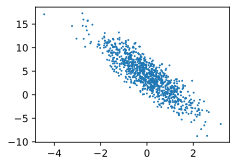

In [7]:
d2l.set_figsize()

# .detach() - 有些pytorch版本中需要先从计算图中分离
# .numpy() - 将tensor转为ndarray
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

定义一个data_iter函数，该函数接受批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [8]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples)) # 生成下标的list
    random.shuffle(indices) # 打乱下标（用于随机取batch_size）
    
    # 从0-(num_examples-1)每次跳batch_size大小选择一个数，作为当前轮选择的最后一个位置
    for i in range(0, num_examples, batch_size): 
        # min()的原因是最后一轮取值可能不足batch_size个
        batch_indices = torch.tensor(indices[i : min(i + batch_size, num_examples)]) # 取出打乱后的训练集下标
        yield features[batch_indices], labels[batch_indices] # 产生打乱后的数据特征和标号
        # yield就是 return 返回一个值，并且记住这个返回的位置，下次迭代就从这个位置后开始。
    
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.3981, -0.1787],
        [-1.0586,  0.2211],
        [ 0.4122,  1.9712],
        [-0.2520,  1.2067],
        [-0.4464,  0.2150],
        [-1.3773,  0.0324],
        [-0.2169,  0.0022],
        [ 0.8875, -0.1707],
        [-1.8596,  1.3742],
        [ 1.4163,  0.1751]]) 
 tensor([[ 5.6043],
        [ 1.3236],
        [-1.6739],
        [-0.3966],
        [ 2.5571],
        [ 1.3329],
        [ 3.7660],
        [ 6.5433],
        [-4.1882],
        [ 6.4227]])


定义初始化模型参数

In [9]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型

In [10]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

定义损失函数

In [11]:
def squared_loss(y_hat, y):
    """均方误差"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法

In [12]:
def sgd(params, lr, batch_size): # params - 包含w和b；lr - 学习率
    """小批量随机梯度下降"""
    # 这里仅涉及更新参数的操作
    with torch.no_grad(): # 更新参数时不计算梯度
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_() # 更新完成后将这一轮的梯度置为0

训练过程

In [20]:
lr = 0.03
num_epochs = 3
net = linreg # 模型假设函数
loss = squared_loss # 损失函数

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # 因为l的形状是(batch_size, 1)，而不是一个标量。因此要进行加和
        # 并以此计算关于[W, b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels) # 计算训练误差
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()): f}') # 前f为格式化输出，后f为小数点位数控制

epoch 1, loss  0.000049
epoch 2, loss  0.000050
epoch 3, loss  0.000049


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [26]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([-8.5831e-05, -6.4659e-04], grad_fn=<SubBackward0>)
b的估计误差：tensor([-0.0003], grad_fn=<RsubBackward1>)
